In [1]:
!pip install kora -q
from kora import drive
drive.link_nbs()

     |████████████████████████████████| 57 kB 1.4 MB/s 
     |████████████████████████████████| 60 kB 6.8 MB/s 
Mounted at /content/drive


In [2]:
import utils

importing Jupyter notebook from /nbs/utils.ipynb
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from keras.applications.efficientnet import EfficientNetB0
from keras.models import Model, Sequential
from keras.layers import TimeDistributed, Input, MaxPooling3D, LSTM, Dense, Conv3D, Conv2D, BatchNormalization, Flatten, Dropout, Convolution2D, Activation, MaxPooling2D, GlobalAveragePooling2D
from keras import losses

In [4]:
""" Global variables"""
NUM_CLASSES = 4
EPOCHS = 10
INSTACK = 16
IMG_SIZE = (224, 224)
LEN_TRAIN = 85


In [5]:
""" Load train generators """

train_gen, val_gen, test_gen = utils.loadOFdatagens()

StopIteration exception: 
length data_files:  85
len data_list :  85
StopIteration exception: 
length data_files:  100
len data_list :  98
StopIteration exception: 
length data_files:  15
len data_list :  15
Success!


In [10]:
from keras.layers.pooling import GlobalAveragePooling3D
def build_OF_model(input_shape= (INSTACK,IMG_SIZE[0],IMG_SIZE[1],3),num_classes=NUM_CLASSES):
  
    model = Sequential()

    model.add(Conv3D(32, kernel_size=3, input_shape=input_shape, padding='same', activation='relu'))
    model.add(MaxPooling3D(pool_size=2))
    model.add(BatchNormalization())

    model.add(Conv3D(32, kernel_size=3, padding='same', activation='relu', kernel_regularizer='l1_l2')) # kernel_initializer='he_normal'
    model.add(MaxPooling3D(pool_size=2, padding='same'))
    model.add(BatchNormalization())
    
    model.add(Dropout(0.2))

    model.add(Conv3D(64, kernel_size=3, padding='same', activation='relu', kernel_regularizer='l1_l2'))
    model.add(MaxPooling3D(pool_size=2, padding='same'))
    model.add(BatchNormalization())

    model.add(Conv3D(128, kernel_size=3, padding='same', activation='relu', kernel_regularizer='l1_l2'))
    model.add(MaxPooling3D(pool_size=2, padding='same'))
    model.add(BatchNormalization())

    model.add(Dropout(0.2))

    model.add(Conv3D(256, kernel_size=3, padding='same', activation='relu', kernel_regularizer='l1_l2'))
    model.add(MaxPooling3D(pool_size=2, padding='same'))
    model.add(BatchNormalization())
    
    model.add(GlobalAveragePooling3D()) #Flatten layer
    model.add(Dense(512, activation='relu'))

    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax', name='pred')) #Output layer


    model.compile(loss='categorical crossentropy', optimizer='Adam', metrics=['accuracy'])
    model.summary()

    return model

In [ ]:
""" Instantiating and compiling model """
of_model = build_OF_model((INSTACK, IMG_SIZE[0], IMG_SIZE[1], 3), NUM_CLASSES)
of_model.compile(optimizer='Adam', loss="categorical_crossentropy", metrics=["accuracy"])
of_history = of_model.fit(train_gen,epochs= EPOCHS, steps_per_epoch = LEN_TRAIN, validation_data=val_gen, validation_steps=15 ,verbose=1)


of_model.save_weights('OF_weights.h5')
of_model.save("OF_model", save_format = 'tf', include_optimizer=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_5 (Conv3D)           (None, 16, 224, 224, 32)  2624      
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 8, 112, 112, 32)  0         
 3D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 8, 112, 112, 32)  128       
 hNormalization)                                                 
                                                                 
 conv3d_6 (Conv3D)           (None, 8, 112, 112, 32)   27680     
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 4, 56, 56, 32)    0         
 3D)                                                             
                                                      

In [8]:
of_history = of_model.fit(train_gen,epochs= EPOCHS, steps_per_epoch = LEN_TRAIN, validation_data=val_gen, validation_steps=15 ,verbose=1)

Epoch 1/10
64/85 [=====================>........] - ETA: 27s - loss: 2.5636 - accuracy: 0.9559

KeyboardInterrupt: ignored

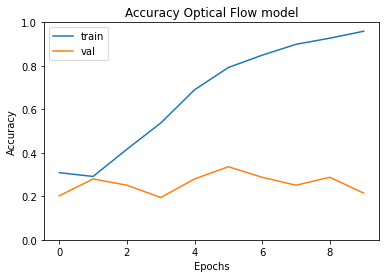

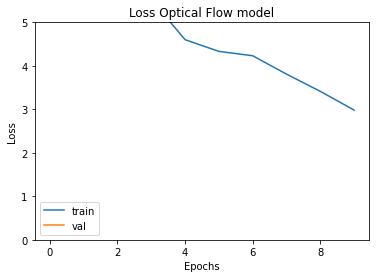

In [9]:
""" Plotting results """
utils.plotAccuracy("Accuracy Optical Flow model", of_history.history['accuracy'], of_history.history['val_accuracy'])
utils.plotLoss("Loss Optical Flow model", of_history.history['loss'], of_history.history['val_loss'])

In [ ]:
#Zip and download the model
!zip -r /content/OF_model.zip /content/OF_model
from google.colab import files
files.download("OF_model.zip")

In [ ]:
# https://medium.com/@anuj_shah/creating-custom-data-generator-for-training-deep-learning-models-part-3-c239297cd5d6
# https://medium.com/swlh/building-a-custom-keras-data-generator-to-generate-a-sequence-of-videoframes-for-temporal-analysis-e364e9b70eb